In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy import stats
from itertools import combinations

import sys
sys.path.append('../mchem_functions')
import PCA_functions as pcf
import multivariate_functions as mvf

In [2]:
chosen_PCs = [1,2]
no_of_components = 5

scaling_method = 'SNV'

replicate_filter = 1

nmr_data_dir = '../../Data/NMR'
nmr_data_arc = 'nmr_archive'

In [3]:
try: os.chdir(nmr_data_dir)
except FileNotFoundError: pass

In [5]:
siteslong = {
    'HM': 'Hare Moss',
    'AM': 'Auchencorth Moss'
}

def wetordry(str):
    if str in ([f'HM-{x}' for x in ['A','B','C','D']] + [f'AM-{x}' for x in ['A','B']]):
        return 'dry'
    else: return 'wet'

def get_attr(s:str):
    s = s.replace('MP-','').replace('PW-','')
    # sample_name = s
    s = s.split('-')
    sample_name = '-'.join(s[:-1])
    site = s[0]
    sitelong = siteslong[site]
    season = s[-2]
    replicate = s[-1]
    wet = wetordry('-'.join(s[:-2]))

    return sample_name,site,sitelong,season,replicate,wet

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

wetordry_colours = {
    'dry': 'orange',
    'wet': 'blue'
}

def add_ticks(ax,axis,mult=.2,no_of_minorticks=1):
    if axis == 'x':
        ax_set_ticks = ax.set_xticks
        lims = ax.get_xlim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.xaxis.set_minor_locator
    elif axis == 'y':
        ax_set_ticks = ax.set_yticks
        lims = ax.get_ylim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.yaxis.set_minor_locator

    step = mult*lims_range
    major_ticks = np.arange(np.min(lims),np.max(lims)+step*.2,step)
    ax_set_ticks(major_ticks)
    set_minor_ticks(AutoMinorLocator(no_of_minorticks+1))

In [6]:
samples_to_exclude = []#['Win2']

In [7]:
path = f"{nmr_data_arc}\\*\\11\\pdata\\*\\integrals.txt"
integral_files = glob.glob(path)
integrals_list = []
attribute_list = []

for file in integral_files:
    if np.all([x not in file for x in samples_to_exclude]):
        # make sure all -'s are separated with at least one space
        with open(file, 'r') as f:
            filedata = f.read()
        filedata = filedata.replace('-', ' -')
        with open(file, 'w') as f:
            f.write(filedata)
        f.close()

        int_df = pd.read_csv(file,skiprows=4,sep=r"\s+")
        integrals_list.append(int_df['Integral'].to_numpy())
        attribute_list.append([*get_attr(file.split('\\')[1])])

        if len(integrals_list[-1]) == 0:
            print(attribute_list[-1])

ppm = np.mean(int_df[['Integrated','Region']].to_numpy(),axis=1)

attribute_array = np.array(attribute_list)
integrals_arr = np.array(integrals_list)
no_of_spectra = len(integrals_arr)
names_unique = np.unique(attribute_array[:,0])

In [8]:
# replicate filter
if replicate_filter:
    integrals_arr = integrals_arr[[np.argmax(attribute_array[:,0]==x) for x in names_unique]]
    attribute_array = attribute_array[[np.argmax(attribute_array[:,0]==x) for x in names_unique]]
    no_of_spectra = len(integrals_arr)

In [9]:
row_sum = np.sum(integrals_arr,axis=1)
integrals_arr = integrals_arr / np.reshape(row_sum,(len(row_sum),1))

In [10]:
# set regions to exclude and exclude them
regions_to_exclude = [[np.min(ppm),0.5],
                      [1.92,2],
                      [4.5,5.07],                  
                      [10,np.max(ppm)]] # 8.4,9

idx_to_exclude = []
for r in regions_to_exclude:
    idx_to_exclude += [*np.where((ppm>=np.min(r))&(ppm<=np.max(r)))[0]]
idx_to_exclude = np.array(idx_to_exclude)
idx_to_include = np.array([x for x in np.arange(len(ppm)) if x not in idx_to_exclude])
ppm = ppm[idx_to_include]
integrals_arr = integrals_arr[:,idx_to_include]

In [11]:
snv = mvf.SNV(integrals_arr)

In [12]:
regions = {
    'alkyl': (0, 2),
    'functionalised alkyl': (2, 3),
    'O-alkyl': (3, 5.5),
    'alkene': (5, 6.5),
    'aromatic': (6, 8),
    'aldehyde': (8, 9)
}
sites = np.unique(attribute_array[:,1])
seas_uniq = np.unique(attribute_array[:,3])


In [13]:
reg_int_list = []
for integr in integrals_arr:
    reg_int_list += [[np.sum(integr[np.where((ppm > np.min(regions[r])) & (ppm <= np.max(regions[r])))]) for r in regions]]

In [14]:
def boxplot_anova(df_phys:pd.DataFrame,costant,costant_col,level_col,variable,ax:plt.Axes=None,title:str=None,
                  ylabel:str=None,xlabel:str=None,titlesize:float|int=16,labelsize:float|int=11,showmeans=False,
                  colours=[],marker='o',**kwargs):
    
    if ax == None:
        fig, ax = plt.subplots()
    
    level_unique = np.unique(df_phys[level_col].to_numpy())

    x = [df_phys[(df_phys[level_col]==l)&(df_phys[costant_col]==costant)][variable].dropna().to_numpy() for l in level_unique]

    bplot = ax.boxplot(x,tick_labels=level_unique,showmeans=showmeans,meanline=showmeans,medianprops=dict(color='k',ls='-'),
                       showfliers=False,patch_artist=True,**kwargs)
    
    if type(colours)!=list: colours=[colours]
    if colours != []:
        if len(bplot['boxes']) ==  len(colours):
            for patch, colour in zip(bplot['boxes'], colours):
                patch.set_facecolor(colour)
        else:
            for patch in bplot['boxes']:
                patch.set_facecolor(colours[0])

    for i in range(len(x)):
        if type(marker) != list: m = marker
        else: m = marker[i]
        ax.scatter([i+1]*len(x[i]),x[i],zorder=2,alpha=.5,marker=m,facecolors='none',edgecolors='k')

    if xlabel == None: xlabel = level_col
    ax.set_xlabel(xlabel,fontsize=labelsize)
    if ylabel == None: ylabel = variable
    ax.set_ylabel(ylabel,fontsize=labelsize)
    
    if title != None: ax.set_title(title,fontsize=titlesize)

    p_dict = {}
    for comb in list(combinations(range(len(x)),2)):
        p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]

    p_rounding = 4
    p_str = '\n'.join([f'$p_{{{key}}}$ = {np.round(p_dict[key],p_rounding)}' for key in p_dict])
    ax.text(.91,.885,p_str,ha='left',va='top',transform=plt.gcf().transFigure)

def cleveland_plot(df,var,var_str:str=None):
    fig_clev, ax_clev = plt.subplots()
    var_arr = df[var].to_numpy()
    ax_clev.scatter(var_arr[np.argsort(var_arr)],range(len(var_arr)))
    ax_clev.set_yticks([])
    if var_str == None: var_str = var
    ax_clev.set_xlabel(var_str,fontsize=11)
    ax_clev.set_ylabel('Observations',fontsize=11)
    ax_clev.set_title(F'Cleveland Dotplot of the {var_str} Data',fontsize=16)

In [15]:
int_df = pd.DataFrame(reg_int_list,index=attribute_array[:,0],columns=regions.keys())
int_df['site'] = attribute_array[:,1]
int_df['season'] = attribute_array[:,3]
int_df['wetness'] = attribute_array[:,5]
# int_df

In [16]:
m_shape = {'AM': 's','HM': 'o'}
sitesshort = {'Auchencorth Moss':'AM', 'Hare Moss':'HM'}
seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

In [17]:
int_df

,alkyl,functionalised alkyl,O-alkyl,alkene,aromatic,aldehyde,site,season,wetness
AM-A-Aut,0.250199,0.237888,0.386975,0.018841,0.060346,0.019196,AM,Aut,dry
AM-A-Win1,0.239510,0.215420,0.358805,0.022792,0.067184,0.010298,AM,Win1,dry
AM-A-Win2,0.197436,0.182758,0.305901,0.013911,0.045699,0.002220,AM,Win2,dry
AM-C-Aut,0.288294,0.281566,0.425065,-0.042816,-0.020890,-0.000867,AM,Aut,wet
AM-C-Win1,0.326074,0.230395,0.280620,0.014853,0.046187,0.038542,AM,Win1,wet
AM-C-Win2,0.251210,0.272186,0.309414,0.030123,0.059036,0.003489,AM,Win2,wet
AM-D-Win1,0.251107,0.217763,0.307970,0.039838,0.083000,0.019009,AM,Win1,wet
AM-D-Win2,0.273448,0.241939,0.306789,0.028189,0.063082,0.005131,AM,Win2,wet
AM-E-Aut,0.226480,0.214328,0.383752,0.047810,0.078709,0.009002,AM,Aut,wet
AM-E-Win1,0.252709,0.270308,0.371759,0.016785,0.061685,-0.008393,AM,Win1,wet


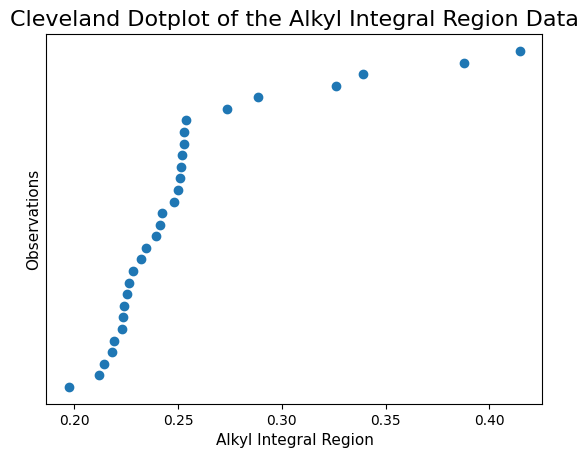

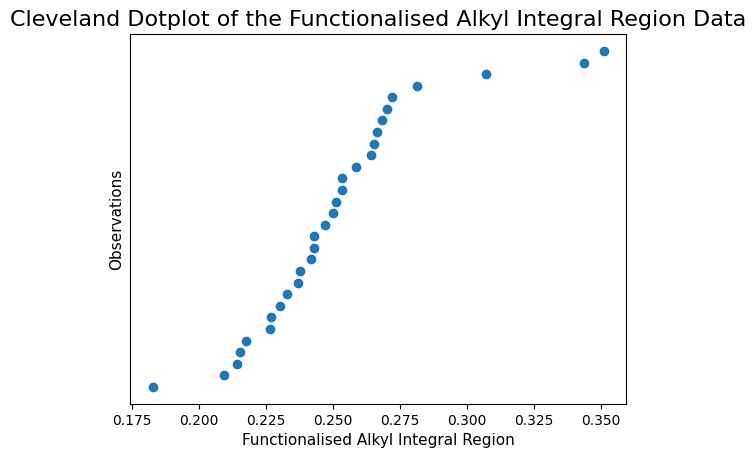

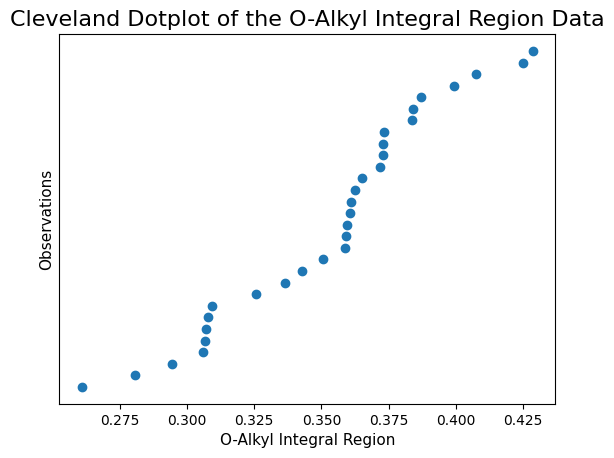

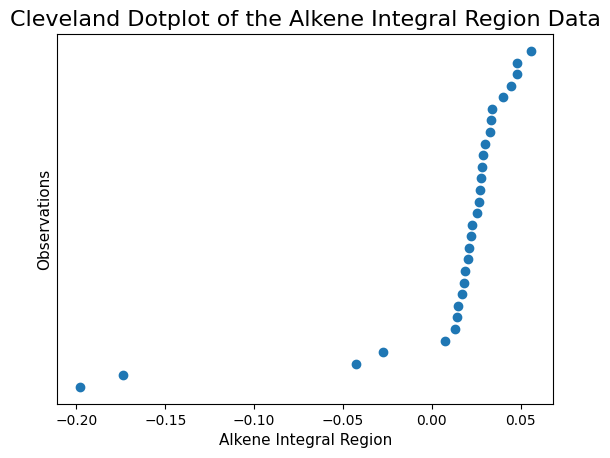

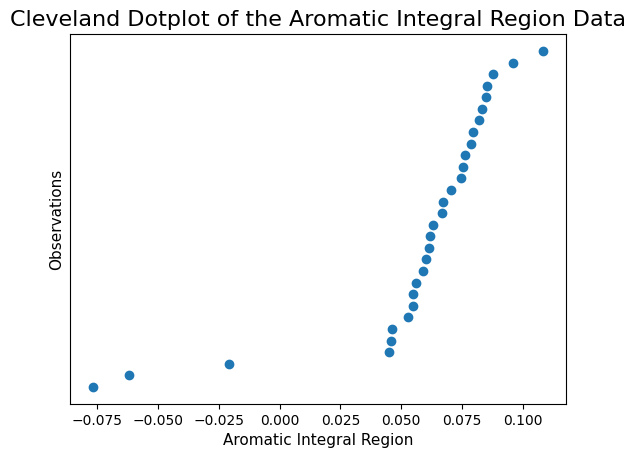

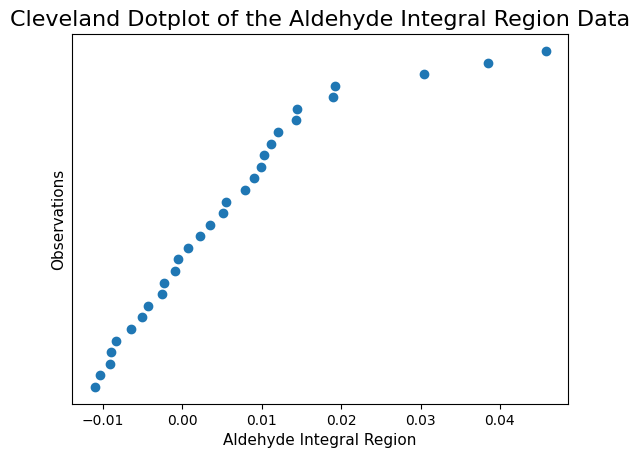

In [18]:
for r in regions:
    var_str = r
    for ch in [' ','-']:
        if ch in var_str: break
    var_str = ch.join([x.capitalize() for x in var_str.split(ch)])
    var_str += ' Integral Region'
    cleveland_plot(int_df,r,var_str=var_str)

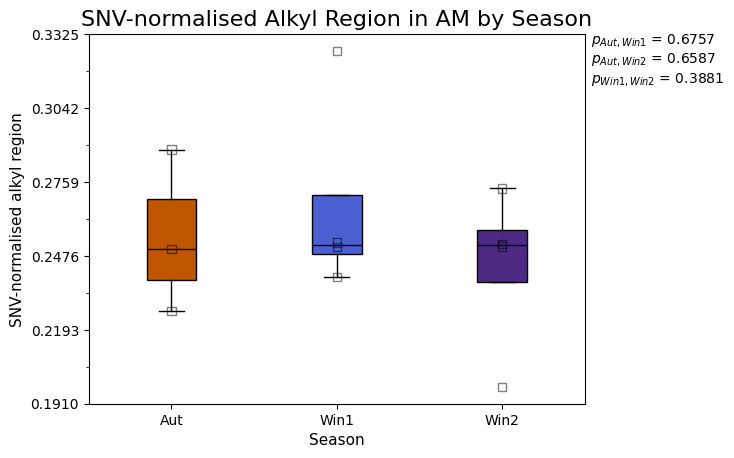

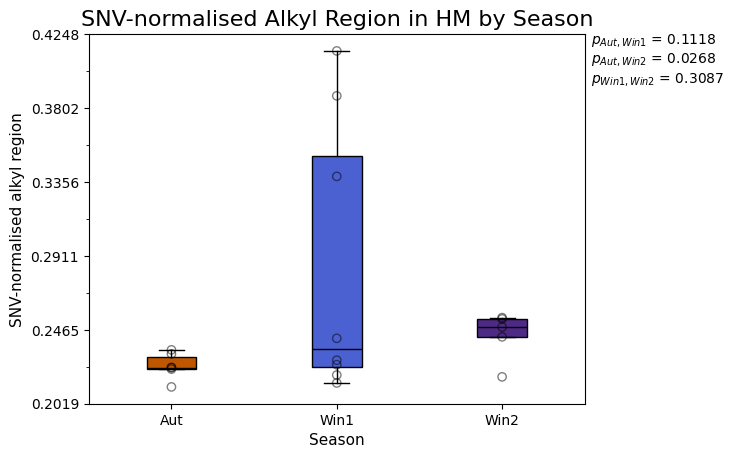

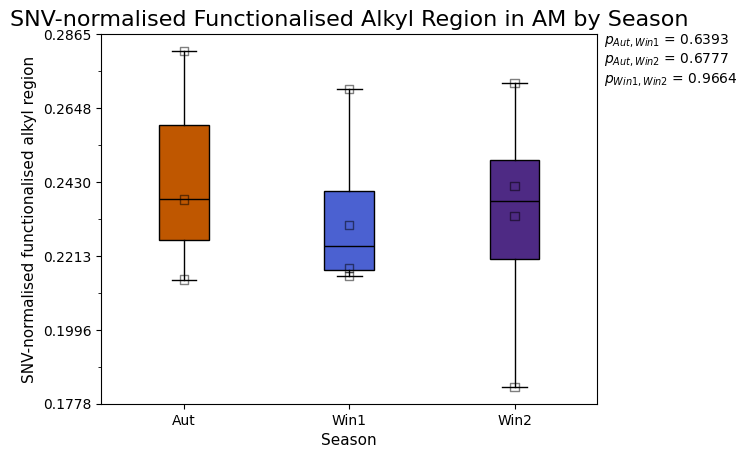

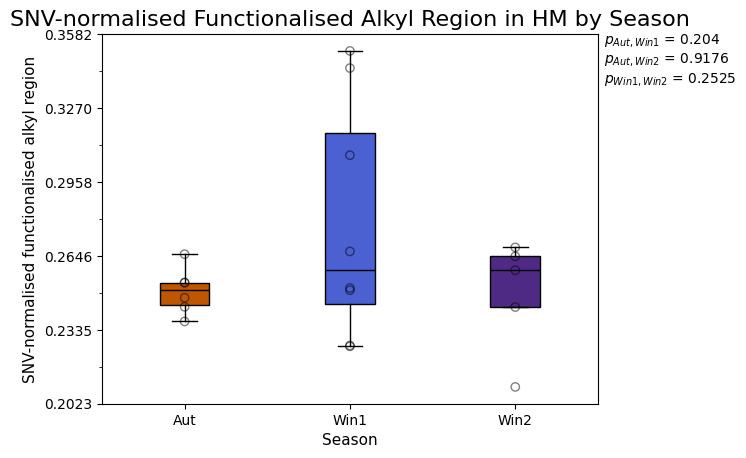

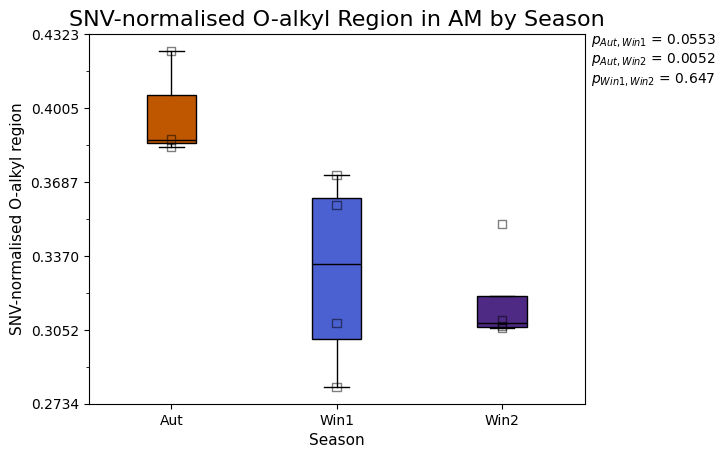

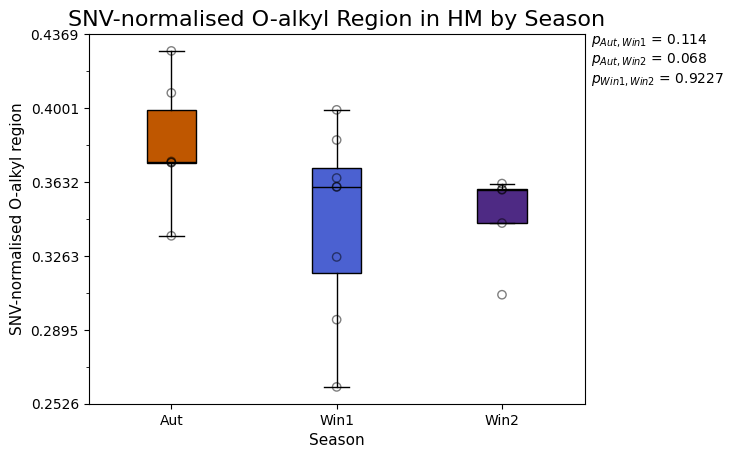

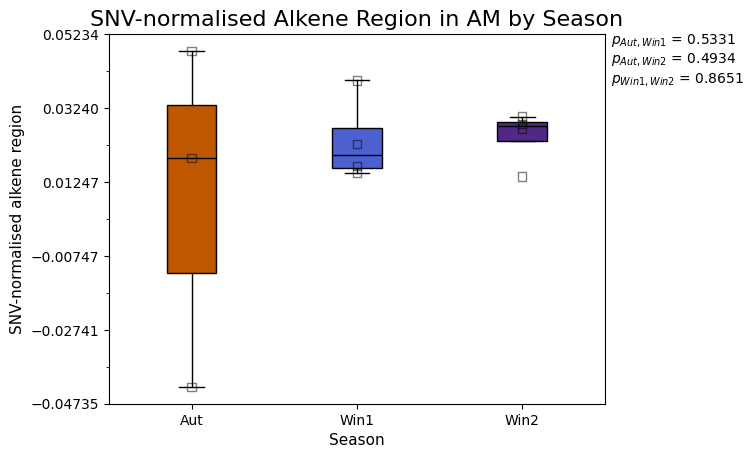

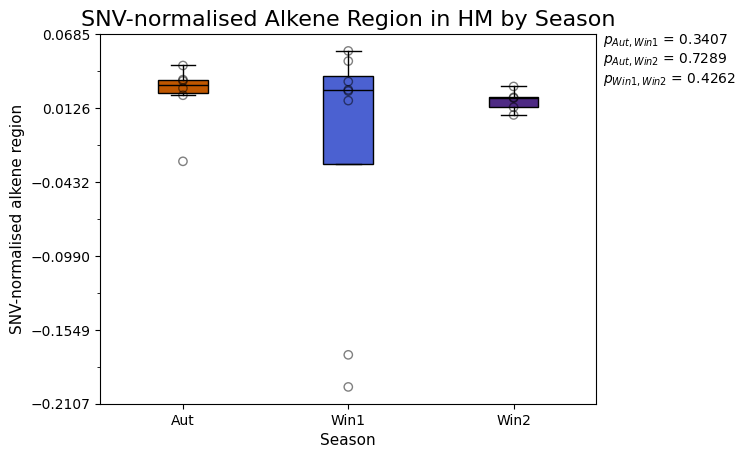

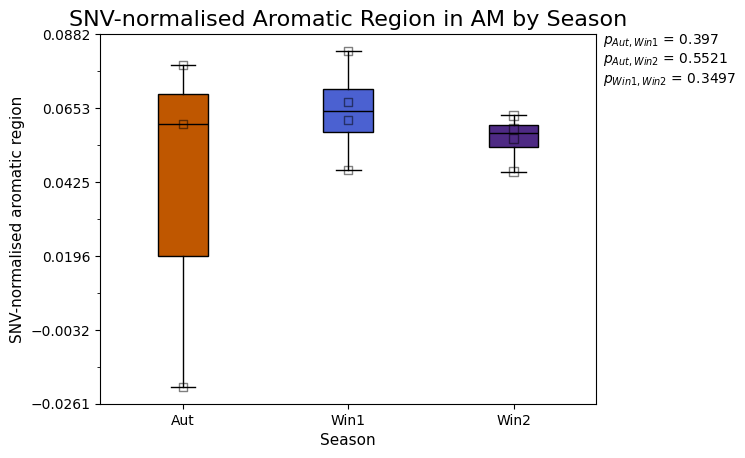

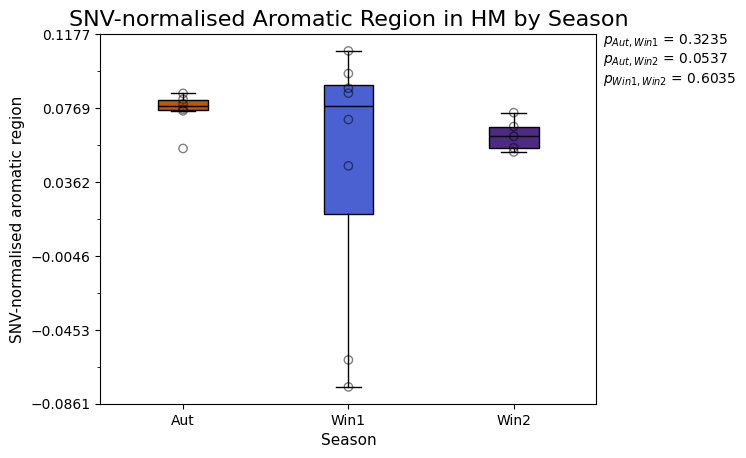

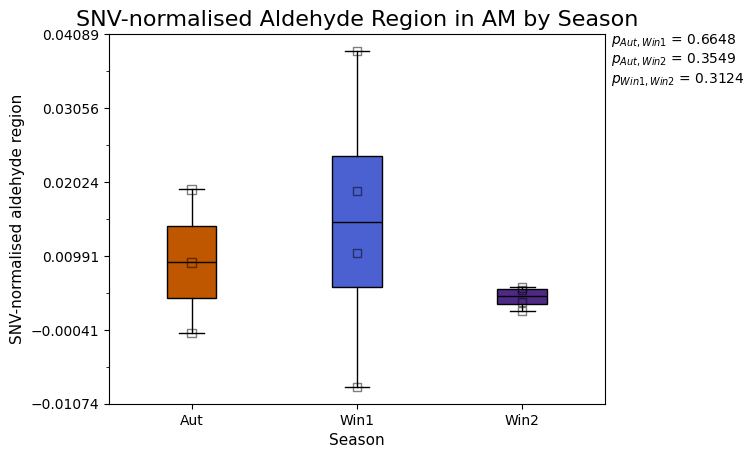

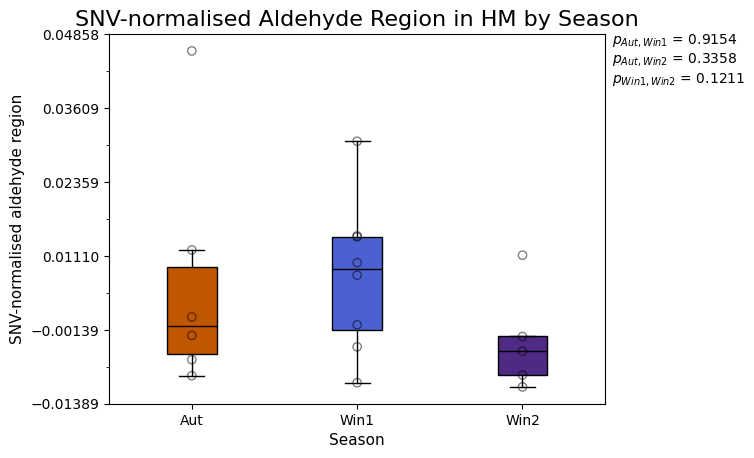

In [20]:
for r in regions.keys():
    for s in sites:
        fig_box, ax_box = plt.subplots()
        ylabel = f'SNV-normalised {r} region'
        boxplot_anova(int_df,s,'site','season',r,ax=ax_box,ylabel=ylabel,xlabel='Season',
                      title=f'{' '.join(y.capitalize() for y in ylabel.split(' ')).replace('Snv','SNV')} in {s} by Season',
                      colours=[seasonal_colours[s] for s in seas_uniq],marker=m_shape[s])
        add_ticks(ax_box,'y')
        fig_box.savefig(f'plots/anova_plots/by_season/{s.replace(' ','_')}_{ylabel.replace(' ','_').replace('/','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')
        
        # for i in range(len(df_metadata)):
        #     ax_box.scatter([i+1]*len(df_metadata[i]),df_metadata[i],zorder=-2,alpha=.5)

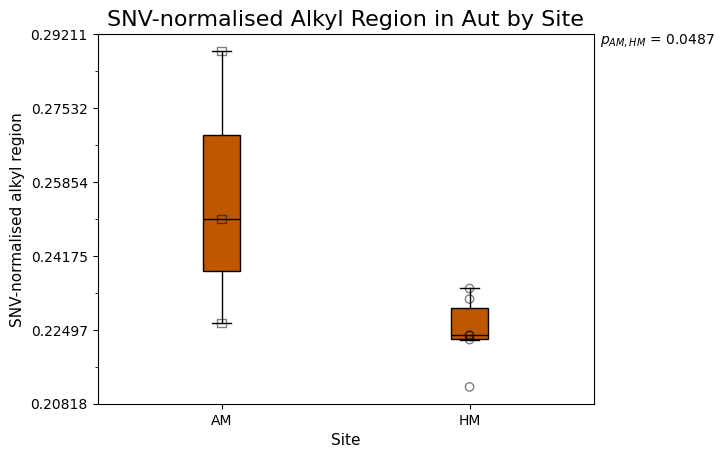

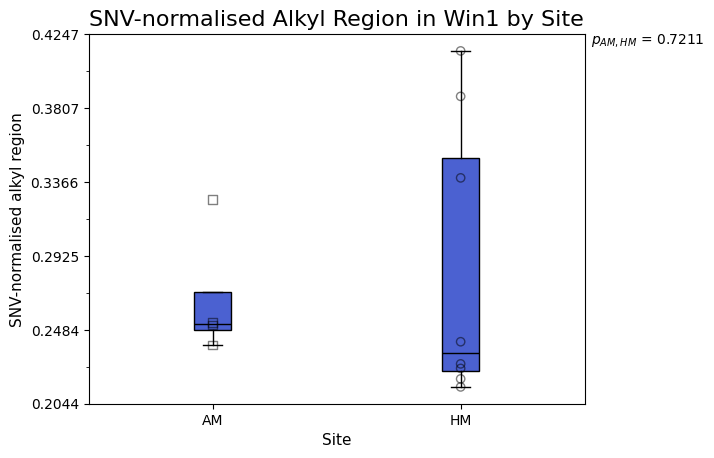

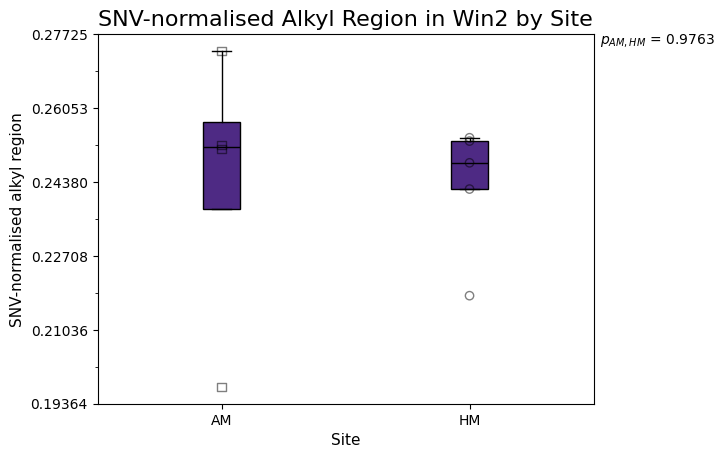

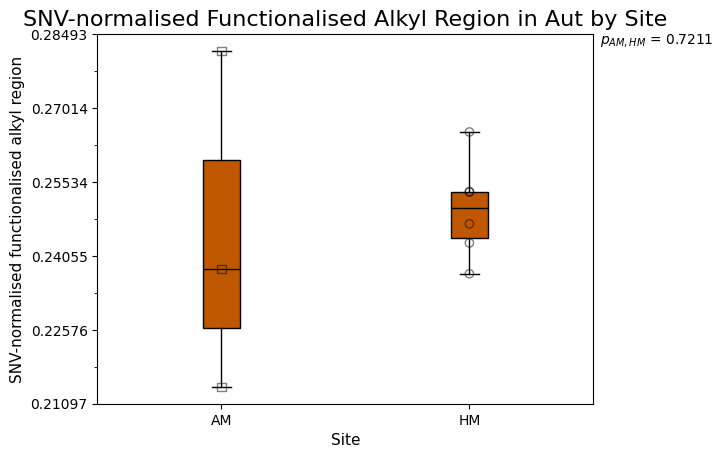

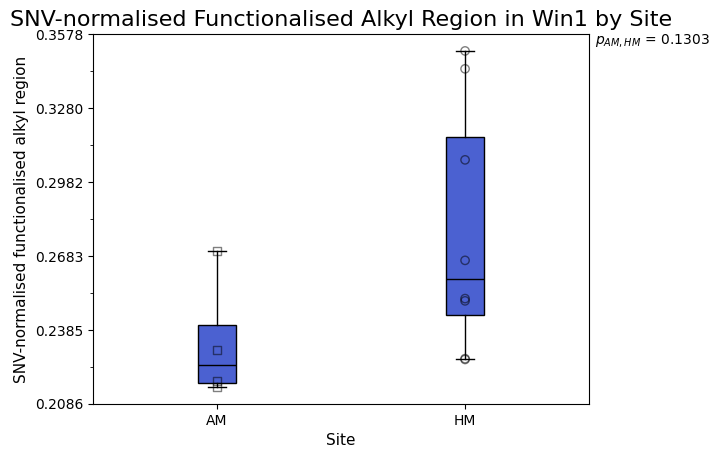

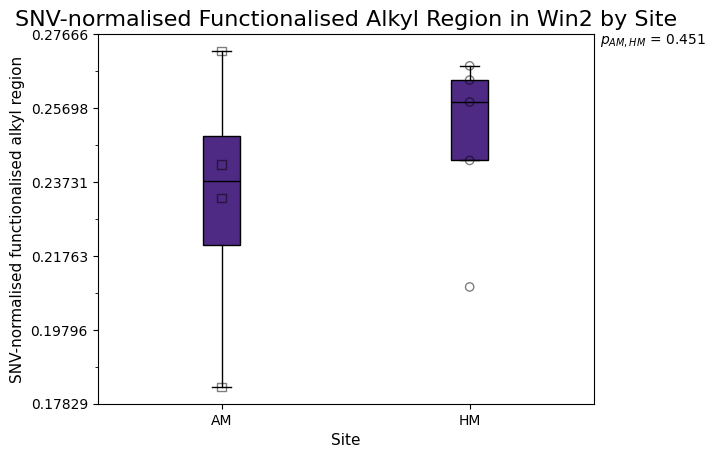

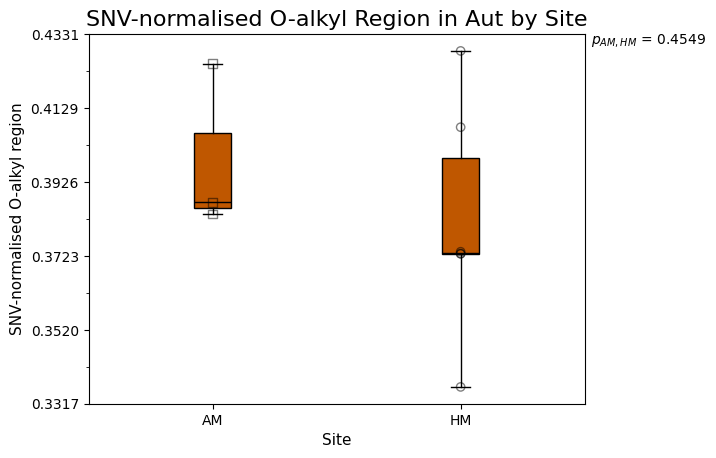

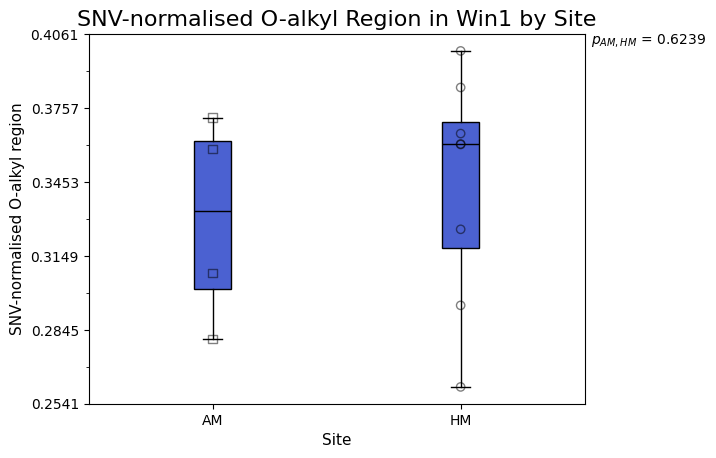

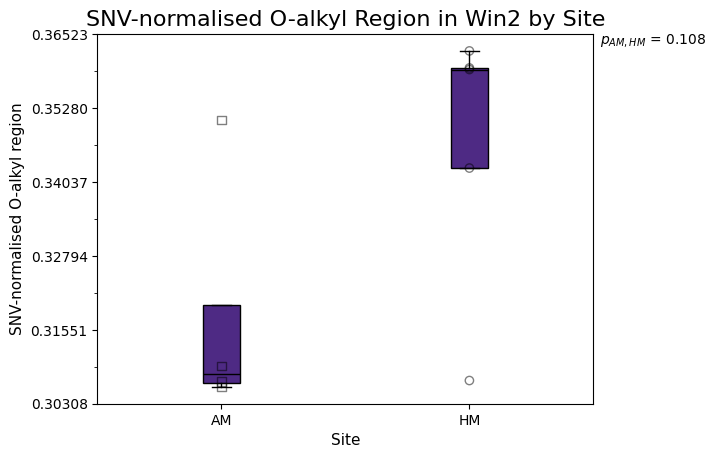

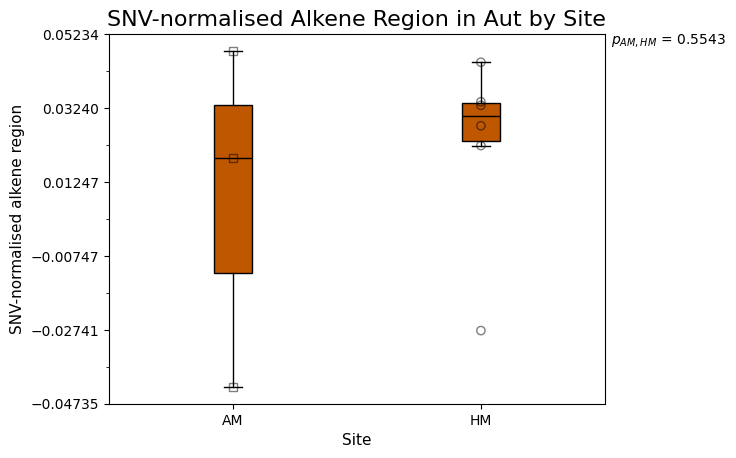

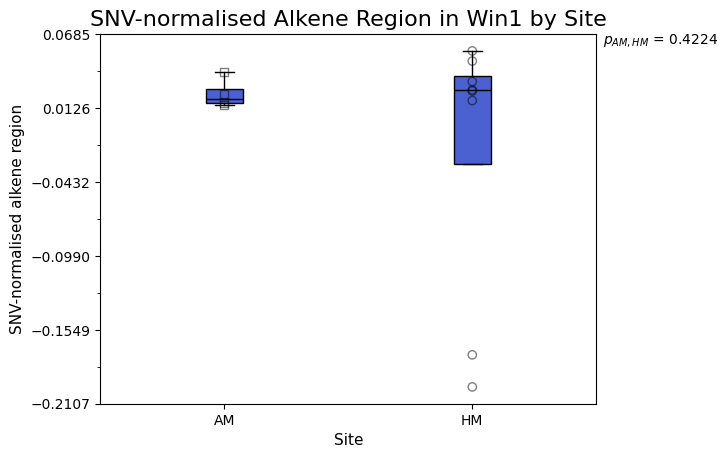

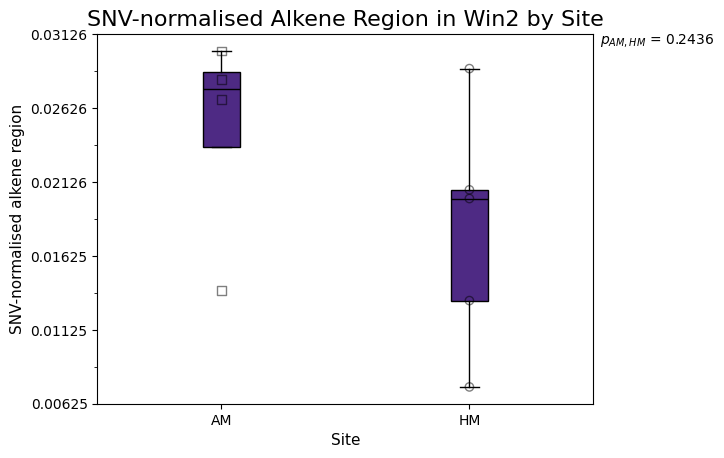

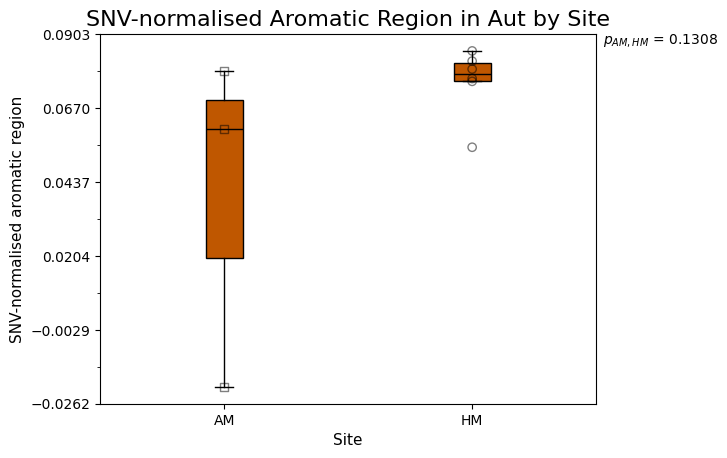

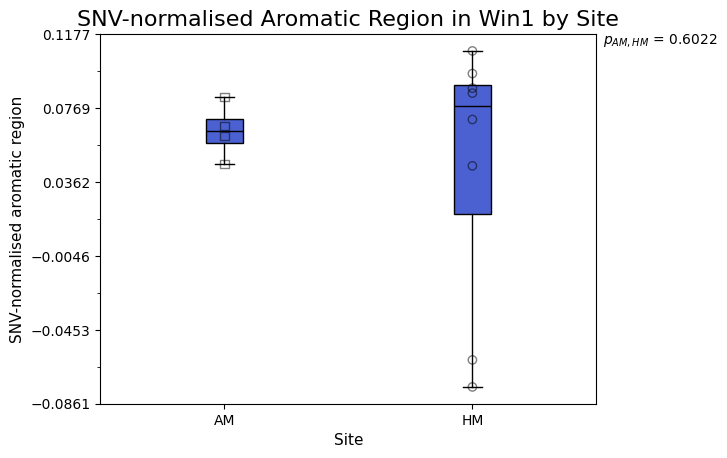

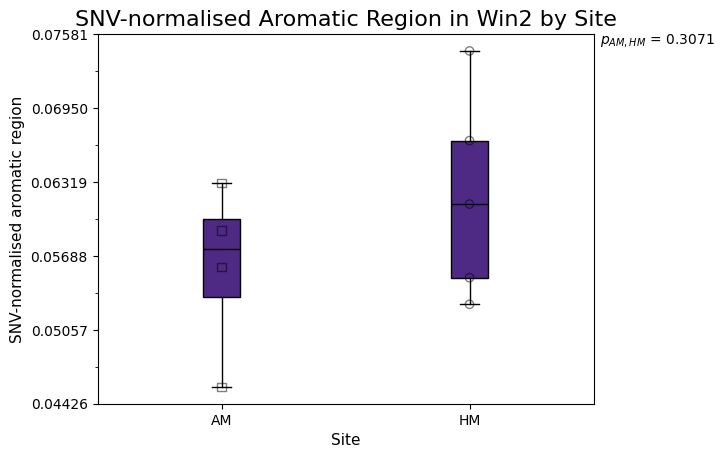

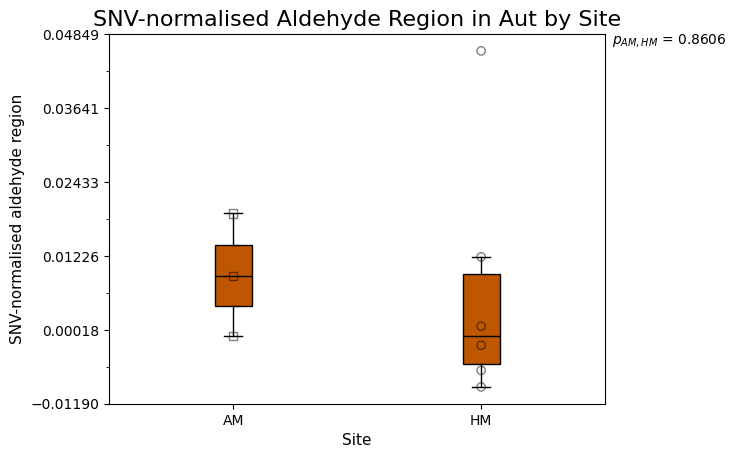

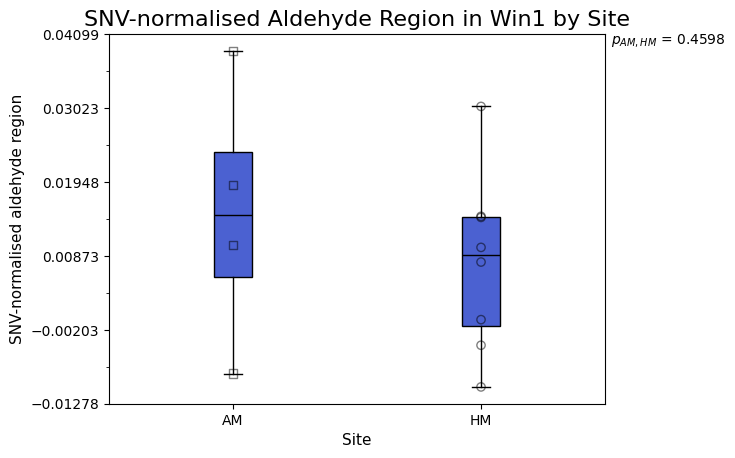

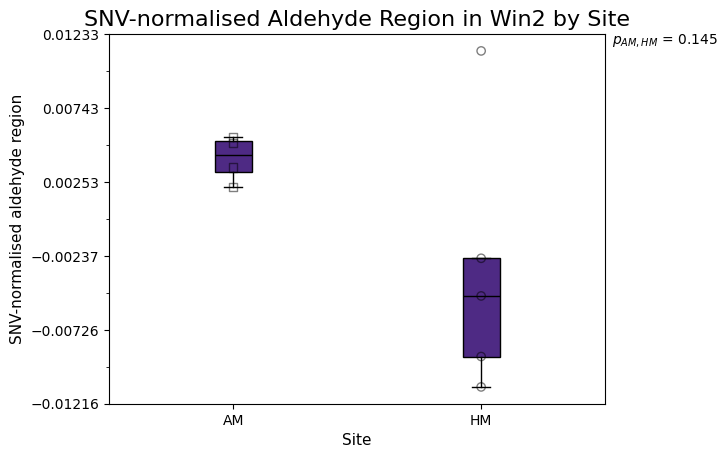

In [21]:
for r in regions.keys():
    for s in seas_uniq:
        fig_box, ax_box = plt.subplots()
        ylabel = f'SNV-normalised {r} region'
        boxplot_anova(int_df,s,'season','site',r,ax=ax_box,ylabel=ylabel,xlabel='Site',
                      title=f'{' '.join(y.capitalize() for y in ylabel.split(' ')).replace('Snv','SNV')} in {s} by Site',
                      colours=seasonal_colours[s],marker=[m_shape[s] for s in m_shape.keys()])
        add_ticks(ax_box,'y')
        fig_box.savefig(f'plots/anova_plots/by_site/{s.replace(' ','_')}_{ylabel.replace(' ','_').replace('/','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')
        
        # for i in range(len(df_metadata)):
        #     ax_box.scatter([i+1]*len(df_metadata[i]),df_metadata[i],zorder=-2,alpha=.5)

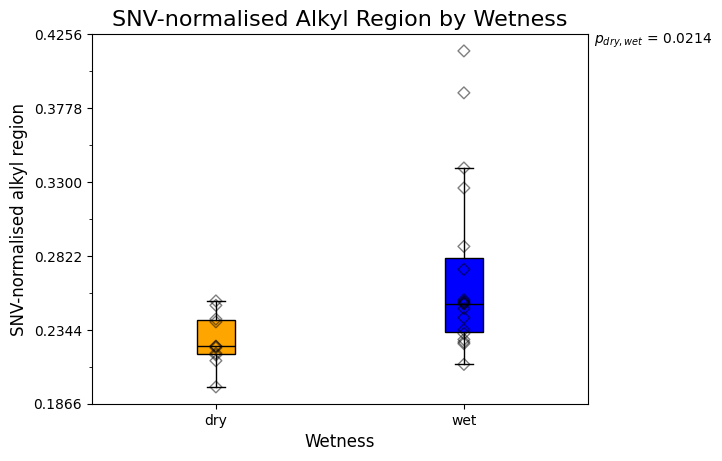

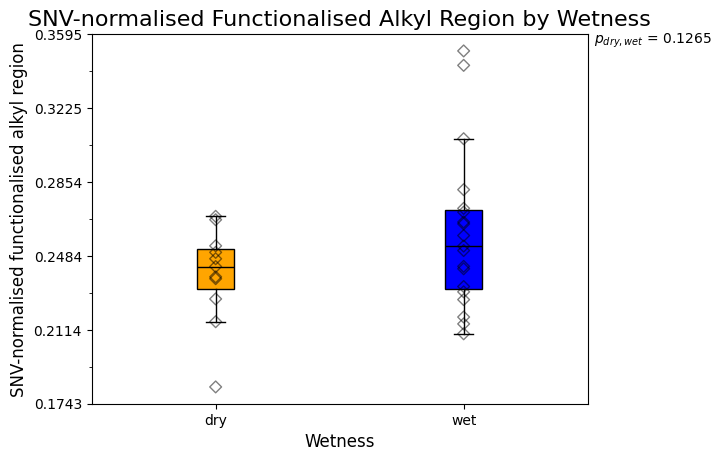

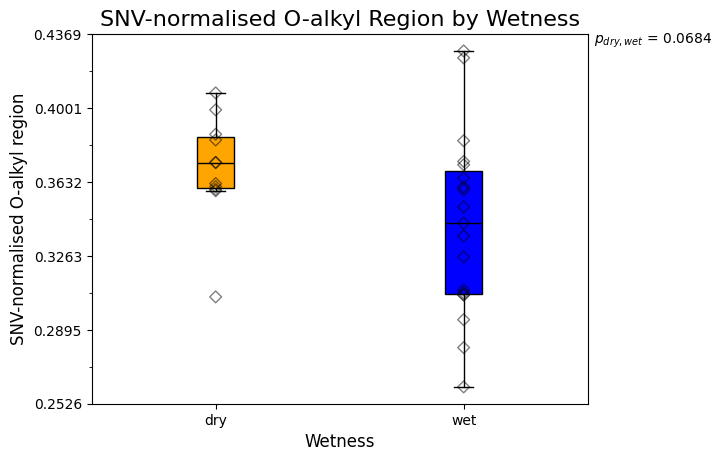

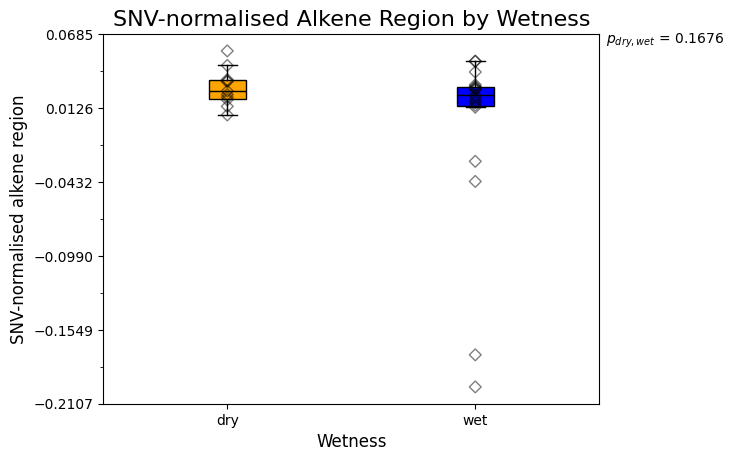

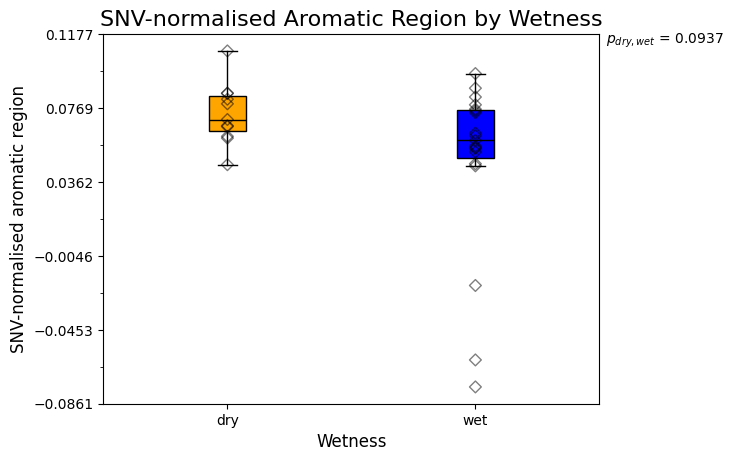

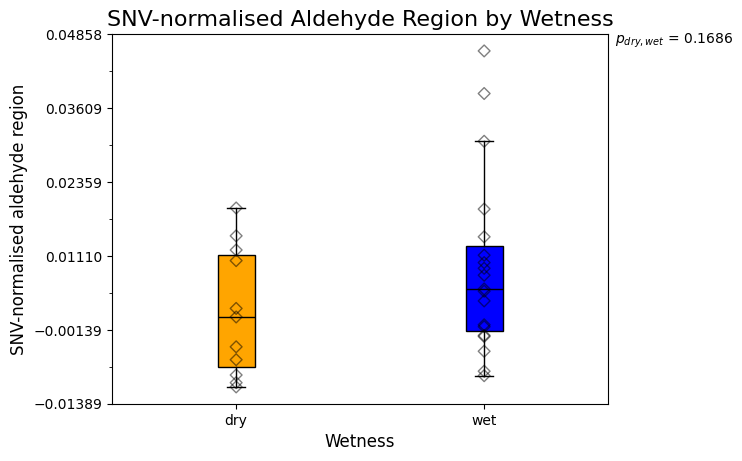

In [22]:
for r in regions.keys():
    # for s in np.unique(int_df['wetness']):
    fig_box, ax_box = plt.subplots()
    ylabel = f'SNV-normalised {r} region'
   
    x = [int_df[int_df['wetness']==l][r].dropna().to_numpy() for l in wetordry_colours.keys()]
    
    bplot = ax_box.boxplot(x,tick_labels=wetordry_colours.keys(),medianprops=dict(color='k',ls='-'),
                           showfliers=False,patch_artist=True)
    for patch, colour in zip(bplot['boxes'], [wetordry_colours[l] for l in wetordry_colours.keys()]):
                patch.set_facecolor(colour)

    for i in range(len(x)):
        ax_box.scatter([i+1]*len(x[i]),x[i],zorder=2,alpha=.5,marker='D',facecolors='none',edgecolors='k')

    ax_box.set_xlabel('Wetness',fontsize=12)
    ax_box.set_ylabel(ylabel,fontsize=12)
    ax_box.set_title(f'{' '.join(y.capitalize() for y in ylabel.split(' ')).replace('Snv','SNV')} by Wetness',fontsize=16)

    p_dict = {}
    for comb in list(combinations(range(len(x)),2)):
        p_dict[f'{list(wetordry_colours.keys())[comb[0]]},{list(wetordry_colours.keys())[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]

    p_rounding = 4
    p_str = '\n'.join([f'$p_{{{key}}}$ = {np.round(p_dict[key],p_rounding)}' for key in p_dict])
    ax_box.text(.91,.885,p_str,ha='left',va='top',transform=plt.gcf().transFigure)
    add_ticks(ax_box,'y')
    fig_box.savefig(f'plots/anova_plots/by_wetness/{ylabel.replace(' ','_').replace('/','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

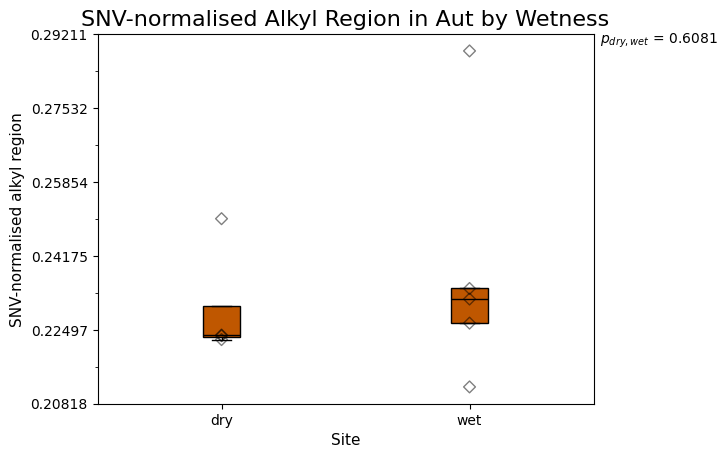

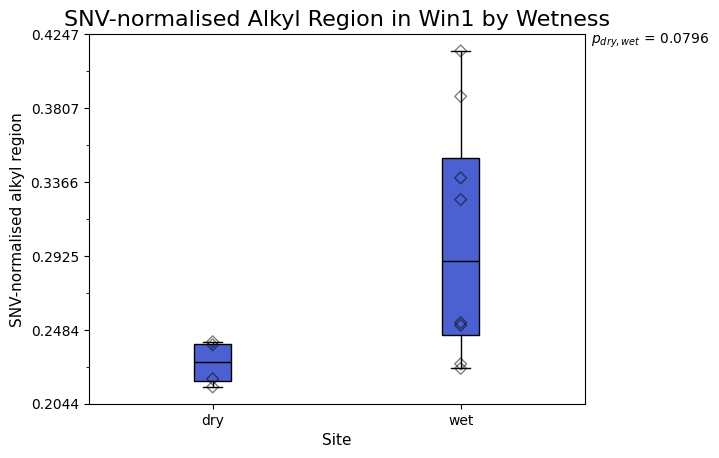

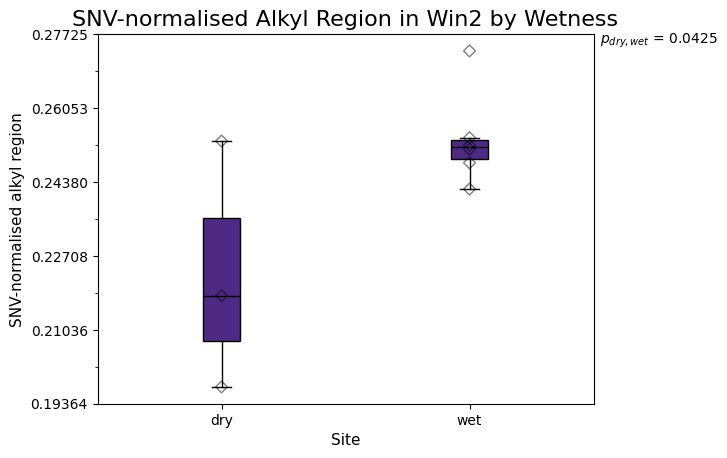

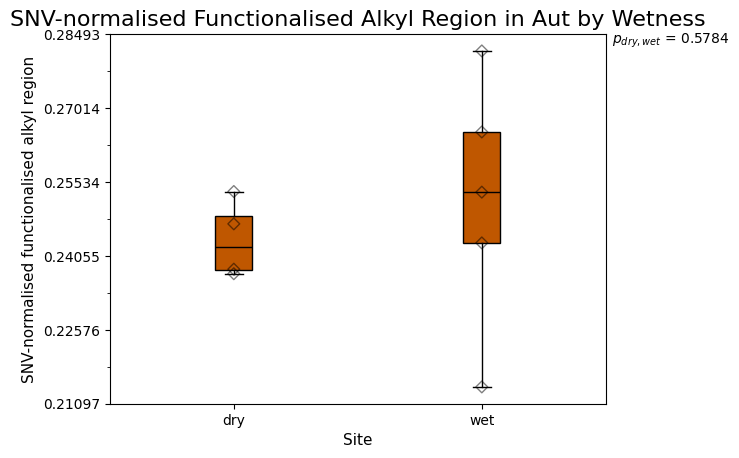

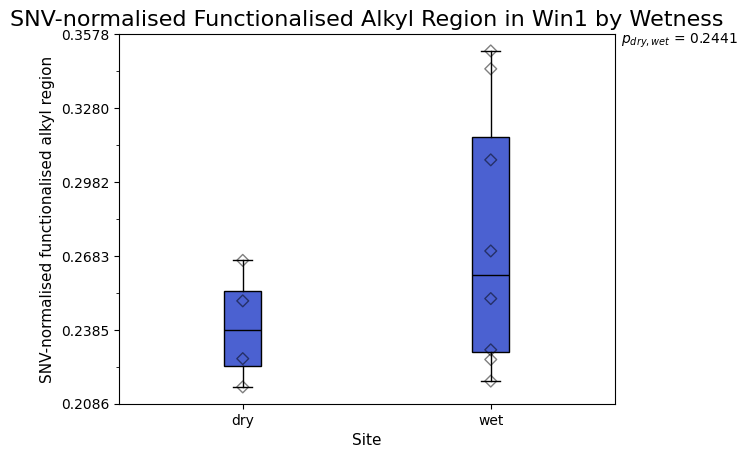

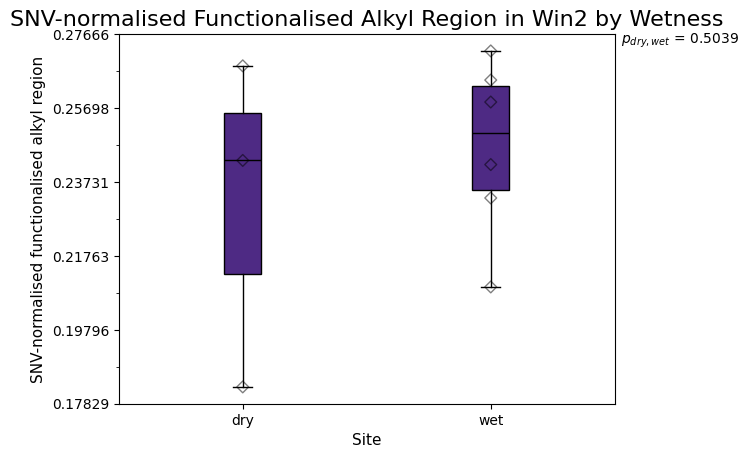

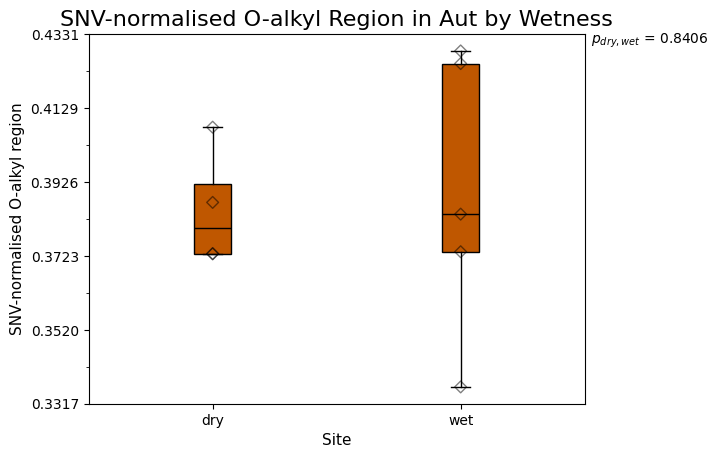

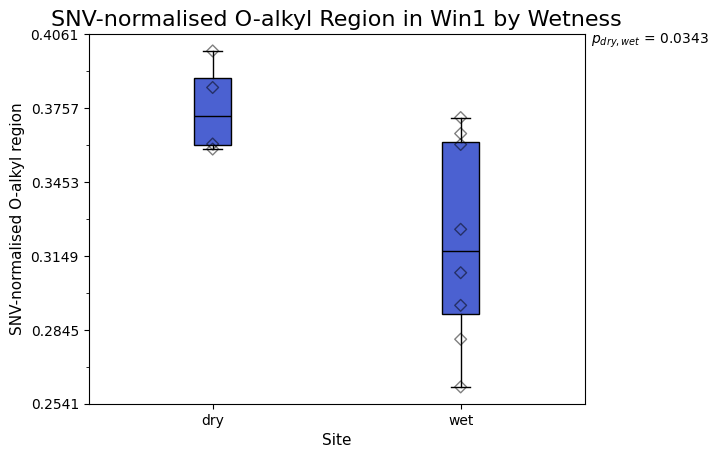

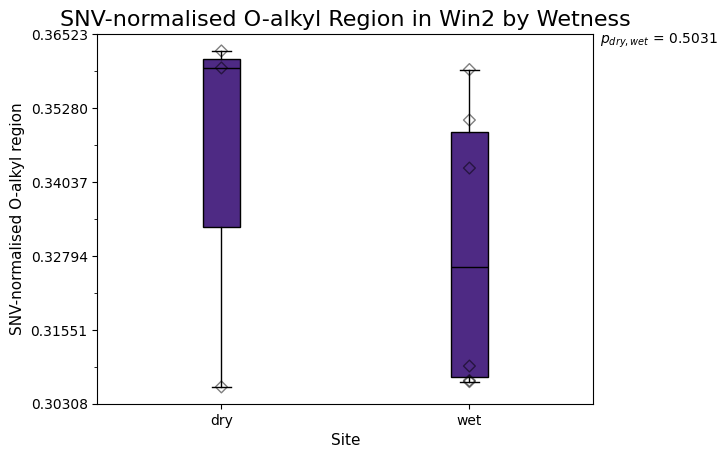

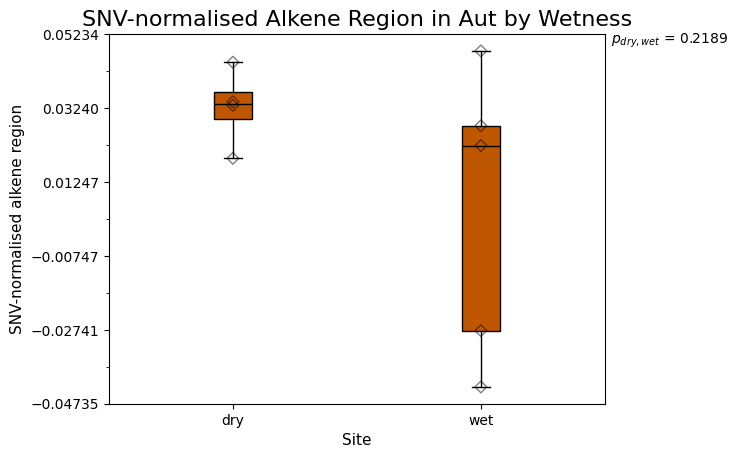

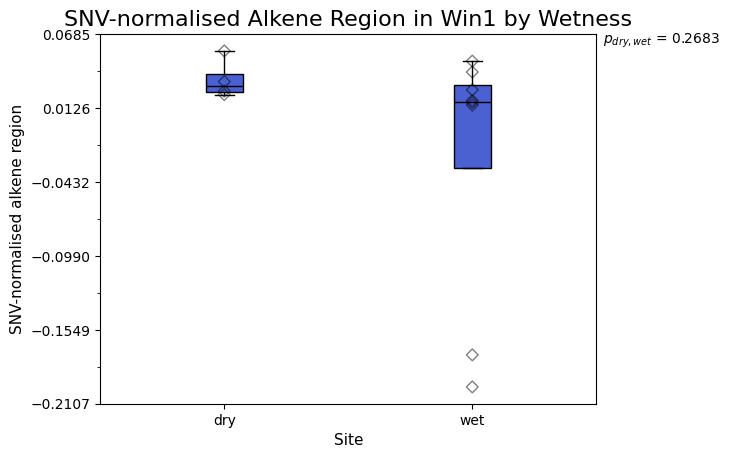

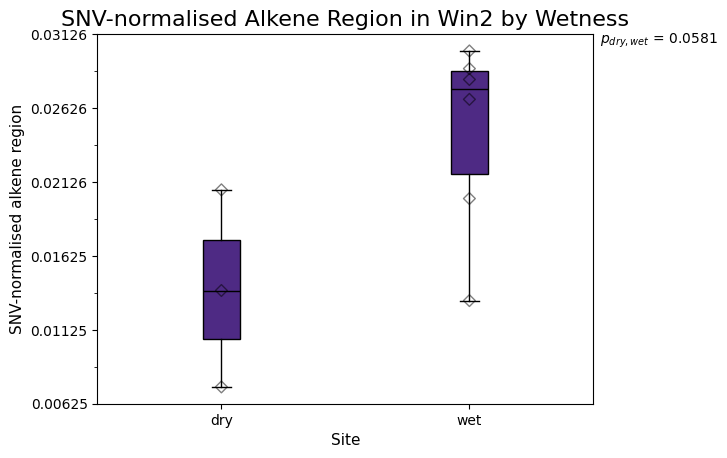

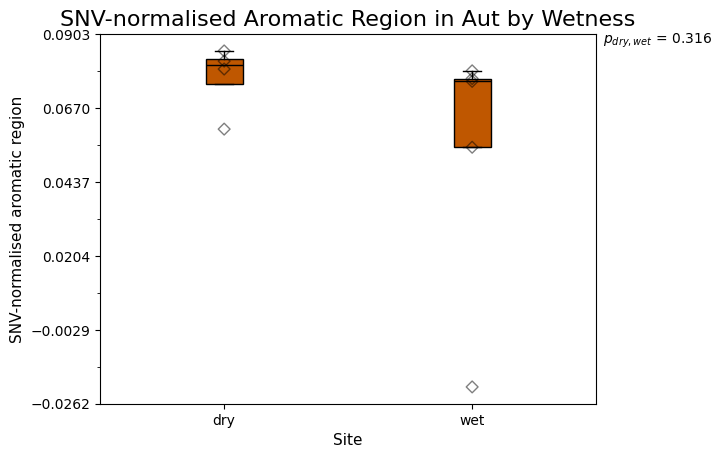

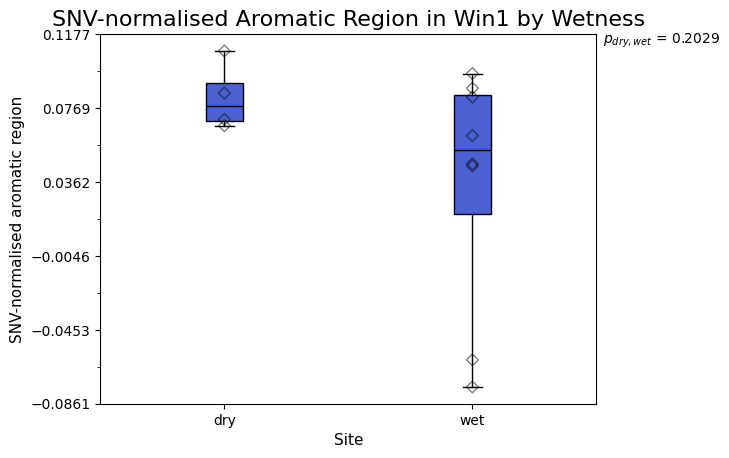

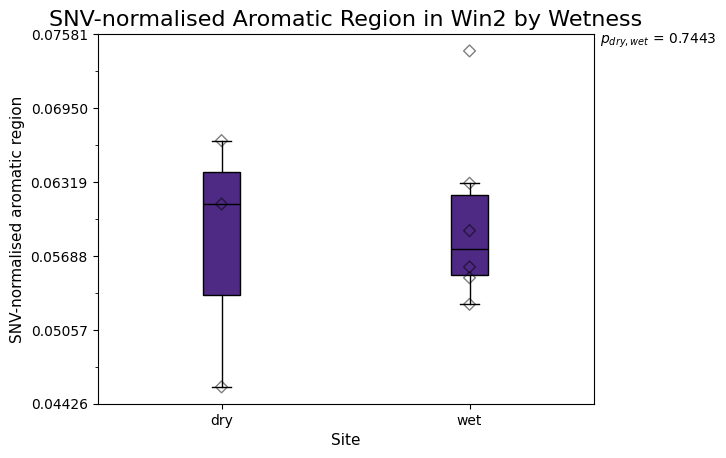

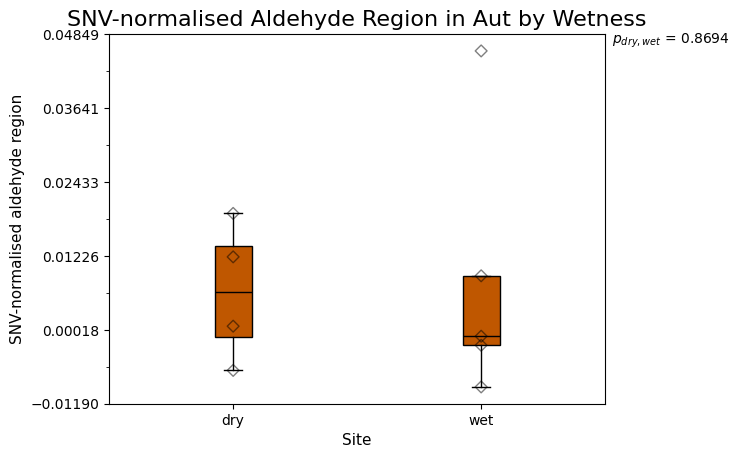

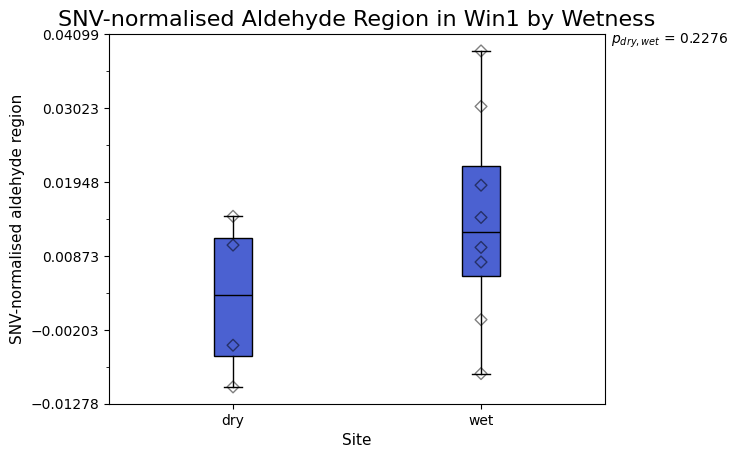

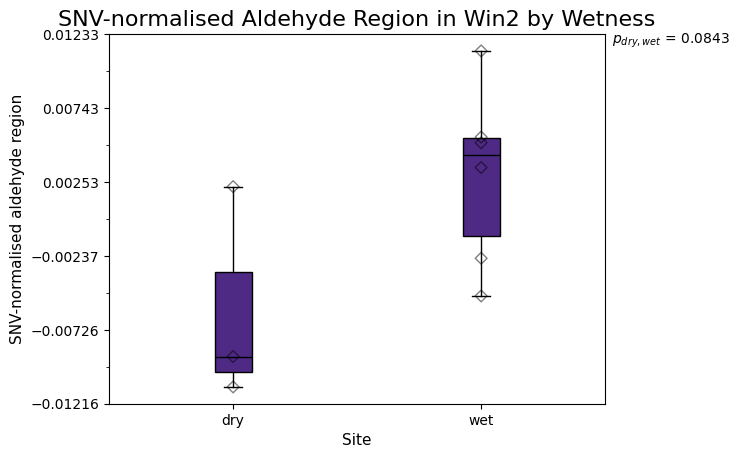

In [23]:
for r in regions.keys():
    for s in seas_uniq:
        fig_box, ax_box = plt.subplots()
        ylabel = f'SNV-normalised {r} region'
        boxplot_anova(int_df,s,'season','wetness',r,ax=ax_box,ylabel=ylabel,xlabel='Site',
                      title=f'{' '.join(y.capitalize() for y in ylabel.split(' ')).replace('Snv','SNV')} in {s} by Wetness',
                      colours=seasonal_colours[s],marker='D')
        add_ticks(ax_box,'y')
        # fig_box.savefig(f'plots/anova_plots/by_site/{s.replace(' ','_')}_{ylabel.replace(' ','_').replace('/','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')